## Import required libraries

In [1]:
import argparse
from typing import Dict

import numpy as np
from sklearn.model_selection import train_test_split

import xgboost_ray as xgb
from xgboost.core import QuantileDMatrix

from codeflare_sdk import Cluster, ClusterConfiguration, TokenAuthentication

## Setup a distributed cluster

### Login to the Openshift cluster   

In [3]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)
if os.environ["CLUSTER_ACCESS_TOKEN"] != "":
    auth = TokenAuthentication(
        token = os.environ["CLUSTER_ACCESS_TOKEN"],
        server = "https://api.mindaro.int.nefast.me:6443",
        skip_tls = True,
    )
    auth.login()

Insecure request warnings have been disabled


### Create a Ray cluster to distribute the workload

In [4]:
cluster_name = "xgboost-distributed-cluster"
cluster = Cluster(ClusterConfiguration(
    name=cluster_name,
    namespace="ray",
    head_cpu_requests='250m',
    head_cpu_limits=1,
    head_memory_requests='250Mi',
    head_memory_limits=6,
    num_workers=2,
    worker_cpu_requests='250m',
    worker_cpu_limits=1,
    worker_memory_requests='250Mi',
    worker_memory_limits=6,
    image="quay.io/modh/ray:2.44.1-py311-cu121",
    write_to_file=False, # When enabled Ray Cluster yaml files are written to /HOME/.codeflare/resources
))

Yaml resources loaded for xgboost-distributed-cluster


Output()

### Bring up the Ray cluster and print its status

In [5]:
cluster.up()
cluster.wait_ready()
cluster.details()

ray_dashboard_uri = cluster.cluster_dashboard_uri()
ray_cluster_uri = cluster.cluster_uri()
print(ray_dashboard_uri)
print(ray_cluster_uri)

A conflict occurred with the RayCluster resource.
Only one RayCluster with the same name is allowed. Please delete or rename the existing RayCluster before creating a new one with the desired name.
Response: {"kind":"Status","apiVersion":"v1","metadata":{},"status":"Failure","message":"rayclusters.ray.io \"xgboost-distributed-cluster\" already exists","reason":"AlreadyExists","details":{"name":"xgboost-distributed-cluster","group":"ray.io","kind":"rayclusters"},"code":409}

Waiting for requested resources to be set up...
Requested cluster is up and running!
Dashboard is ready!


                          🚀 CodeFlare Cluster Details 🚀                         
                                                                                  
 ╭──────────────────────────────────────────────────────────────────────────────╮ 
 │   Name                                                                       │ 
 │   xgboost-distributed-cluster                                    Active ✅   │ 
 │                                                                              │ 
 │   URI: ray://xgboost-distributed-cluster-head-svc.ray.svc:10001              │ 
 │                                                                              │ 
 │   ]8;id=681067;https://ray-dashboard-xgboost-distributed-cluster-ray.apps.mindaro.int.nefast.me\Dashboard🔗]8;;\                                                                │ 
 │                                                                              │ 
 │                       Cluster Resources                                      │ 
 │   ╭── Workers ──╮  ╭───────── Worker specs(each) ─────────╮                  │ 
 │   │  # Workers  │  │  Memory      CPU         GPU         │                  │ 
 │   │             │  │                                      │                  │ 
 │   │  2          │  │  250Mi~6G    250m~1      0           │                  │ 
 │   │             │  │                                      │                  │ 
 │   ╰─────────────╯  ╰──────────────────────────────────────╯                  │ 
 ╰──────────────────────────────────────────────────────────────────────────────╯

https://ray-dashboard-xgboost-distributed-cluster-ray.apps.mindaro.int.nefast.me
ray://xgboost-distributed-cluster-head-svc.ray.svc:10001


### Bind Ray to the new cluster

In [6]:
from codeflare_sdk import generate_cert

# Create required TLS cert and export the environment variables to enable TLS
generate_cert.generate_tls_cert(cluster_name, cluster.config.namespace)
generate_cert.export_env(cluster_name, cluster.config.namespace)

import ray

ray_cluster_uri = "ray://rayclient-xgboost-distributed-cluster-ray.apps.mindaro.int.nefast.me"

# Reset the ray context in case there's already one.
print("Connecting to remote Ray cluster at: ", ray_cluster_uri)
ray.shutdown()

# Load dependencies to then install on the Ray cluster.
with open("compute.requirements.txt", "r") as f:
    requirements = f.read().splitlines()

runtime_env = {"pip": requirements}
ray.init(address=ray_cluster_uri, runtime_env=runtime_env)

print("Ray cluster is up and running: ", ray.is_initialized())

2025-05-29 21:35:44,530	INFO client_builder.py:244 -- Passing the following kwargs to ray.init() on the server: log_to_driver


Connecting to remote Ray cluster at:  ray://rayclient-xgboost-distributed-cluster-ray.apps.mindaro.int.nefast.me


SIGTERM handler is not set because current thread is not the main thread.


Ray cluster is up and running:  True


(_wrapped pid=1756729) [RayXGBoost] Created 2 new actors (2 total actors). Waiting until actors are ready for training.
(_wrapped pid=1756729) [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=788884, ip=10.128.0.120) [19:36:27] task [xgboost.ray]:139936991048208 got new rank 0
(_RemoteRayXGBoostActor pid=1337540, ip=10.128.1.197) [19:36:27] task [xgboost.ray]:140275512232464 got new rank 1


(_wrapped pid=1756729) [0]	Train-quantile:3.08666	Test-quantile:3.09100
(_wrapped pid=1756729) [1]	Train-quantile:2.93452	Test-quantile:2.93979
(_wrapped pid=1756729) [2]	Train-quantile:2.79052	Test-quantile:2.79619
(_wrapped pid=1756729) [3]	Train-quantile:2.65489	Test-quantile:2.66022
(_wrapped pid=1756729) [4]	Train-quantile:2.52671	Test-quantile:2.53171
(_wrapped pid=1756729) [5]	Train-quantile:2.40601	Test-quantile:2.41068
(_wrapped pid=1756729) [6]	Train-quantile:2.29109	Test-quantile:2.29563
(_wrapped pid=1756729) [7]	Train-quantile:2.18284	Test-quantile:2.18762
(_wrapped pid=1756729) [8]	Train-quantile:2.08036	Test-quantile:2.08565
(_wrapped pid=1756729) [9]	Train-quantile:1.98387	Test-quantile:1.98965
(_wrapped pid=1756729) [10]	Train-quantile:1.89253	Test-quantile:1.89865
(_wrapped pid=1756729) [11]	Train-quantile:1.80623	Test-quantile:1.81258
(_wrapped pid=1756729) [12]	Train-quantile:1.72460	Test-quantile:1.73109
(_wrapped pid=1756729) [13]	Train-quantile:1.64762	Test-quant

(_wrapped pid=1756729) [RayXGBoost] Finished XGBoost training on training data with total N=90,000 in 27.23 seconds (8.78 pure XGBoost training time).
(_wrapped pid=1756729) [RayXGBoost] Created 2 new actors (2 total actors). Waiting until actors are ready for training.
(_wrapped pid=1756729) [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=789101, ip=10.128.0.120) [19:36:49] task [xgboost.ray]:139792556947216 got new rank 0
(_RemoteRayXGBoostActor pid=1337746, ip=10.128.1.197) [19:36:49] task [xgboost.ray]:139812465052176 got new rank 1


(_wrapped pid=1756729) [0]	Train-rmse:8.29170	Test-rmse:8.57662
(_wrapped pid=1756729) [1]	Train-rmse:8.01392	Test-rmse:8.31490
(_wrapped pid=1756729) [2]	Train-rmse:7.74907	Test-rmse:8.06622
(_wrapped pid=1756729) [3]	Train-rmse:7.49666	Test-rmse:7.83032
(_wrapped pid=1756729) [4]	Train-rmse:7.25624	Test-rmse:7.60647
(_wrapped pid=1756729) [5]	Train-rmse:7.02735	Test-rmse:7.39432
(_wrapped pid=1756729) [6]	Train-rmse:6.80960	Test-rmse:7.19326
(_wrapped pid=1756729) [7]	Train-rmse:6.60251	Test-rmse:7.00307
(_wrapped pid=1756729) [8]	Train-rmse:6.40571	Test-rmse:6.82323
(_wrapped pid=1756729) [9]	Train-rmse:6.21881	Test-rmse:6.65320
(_wrapped pid=1756729) [10]	Train-rmse:6.04142	Test-rmse:6.49263
(_wrapped pid=1756729) [11]	Train-rmse:5.87317	Test-rmse:6.34122
(_wrapped pid=1756729) [12]	Train-rmse:5.71370	Test-rmse:6.19847
(_wrapped pid=1756729) [13]	Train-rmse:5.56266	Test-rmse:6.06407
(_wrapped pid=1756729) [14]	Train-rmse:5.41973	Test-rmse:5.93753
(_wrapped pid=1756729) [15]	Train-r

(_wrapped pid=1756729) [RayXGBoost] Finished XGBoost training on training data with total N=90,000 in 12.45 seconds (3.90 pure XGBoost training time).
Log channel is reconnecting. Logs produced while the connection was down can be found on the head node of the cluster in `ray_client_server_[port].out`
2025-05-29 22:21:29,840	WARNING dataclient.py:403 -- Encountered connection issues in the data channel. Attempting to reconnect.


## Start the demo prediction on the Ray cluster

In [7]:
def f(x: np.ndarray) -> np.ndarray:
    """The function to predict."""
    return np.sin(x) * x

In [8]:
import xgboost_ray as xgb

"""Train a quantile regression model."""
rng = np.random.RandomState(1994)
# Generate a synthetic dataset for demo, the generate process is from the sklearn
# example.
X = np.atleast_2d(rng.uniform(0, 20.0, size=100000)).T
expected_y = f(X).ravel()

sigma = 0.5 + X.ravel() / 20.0
noise = rng.lognormal(sigma=sigma) - np.exp(sigma**2.0 / 2.0)
y = expected_y + noise

# Train on 0.05 and 0.95 quantiles. The model is similar to multi-class and
# multi-target models.
alpha = np.array([0.05, 0.25, 0.5, 0.75, 0.95])
evals_result: Dict[str, Dict] = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng, test_size=0.1)
# We will be using the `hist` tree method, quantile DMatrix can be used to preserve
# memory (which has nothing to do with quantile regression itself, see its document
# for details).
# Do not use the `exact` tree method for quantile regression, otherwise the
# performance might drop.
Xy = xgb.RayDMatrix(X_train, y_train)
# use Xy as a reference
Xy_test = xgb.RayDMatrix(X_test, y_test, ref=Xy)

booster = xgb.train(
    {
        # Use the quantile objective function.
        "objective": "reg:quantileerror",
        "tree_method": "hist",
        "quantile_alpha": alpha,
        # Let's try not to overfit.
        "learning_rate": 0.04,
        "max_depth": 15,
    },
    Xy,
    num_boost_round=32,
    ray_params=xgb.RayParams(num_actors=2, cpus_per_actor=1),
    early_stopping_rounds=2,
    # The evaluation result is a weighted average across multiple quantiles.
    evals=[(Xy, "Train"), (Xy_test, "Test")],
    evals_result=evals_result,
)
xx = np.atleast_2d(np.linspace(0, 20, 100000)).T
scores = booster.inplace_predict(xx)
# dim 1 is the quantiles
assert scores.shape[0] == xx.shape[0]
assert scores.shape[1] == alpha.shape[0]

y_lower = scores[:, 0]  # alpha=0.05
y_med = scores[:, 1]  # alpha=0.5, median
y_upper = scores[:, 2]  # alpha=0.95

# Train a mse model for comparison
booster = xgb.train(
    {
        "objective": "reg:squarederror",
        "tree_method": "hist",
        # Let's try not to overfit.
        "learning_rate": 0.04,
        "max_depth": 15,
    },
    Xy,
    num_boost_round=32,
    early_stopping_rounds=2,
    evals=[(Xy, "Train"), (Xy_test, "Test")],
    evals_result=evals_result,
    ray_params=xgb.RayParams(num_actors=2, cpus_per_actor=1)
)
xx = np.atleast_2d(np.linspace(0, 20, 100000)).T
y_pred = booster.inplace_predict(xx)

## Plot the results

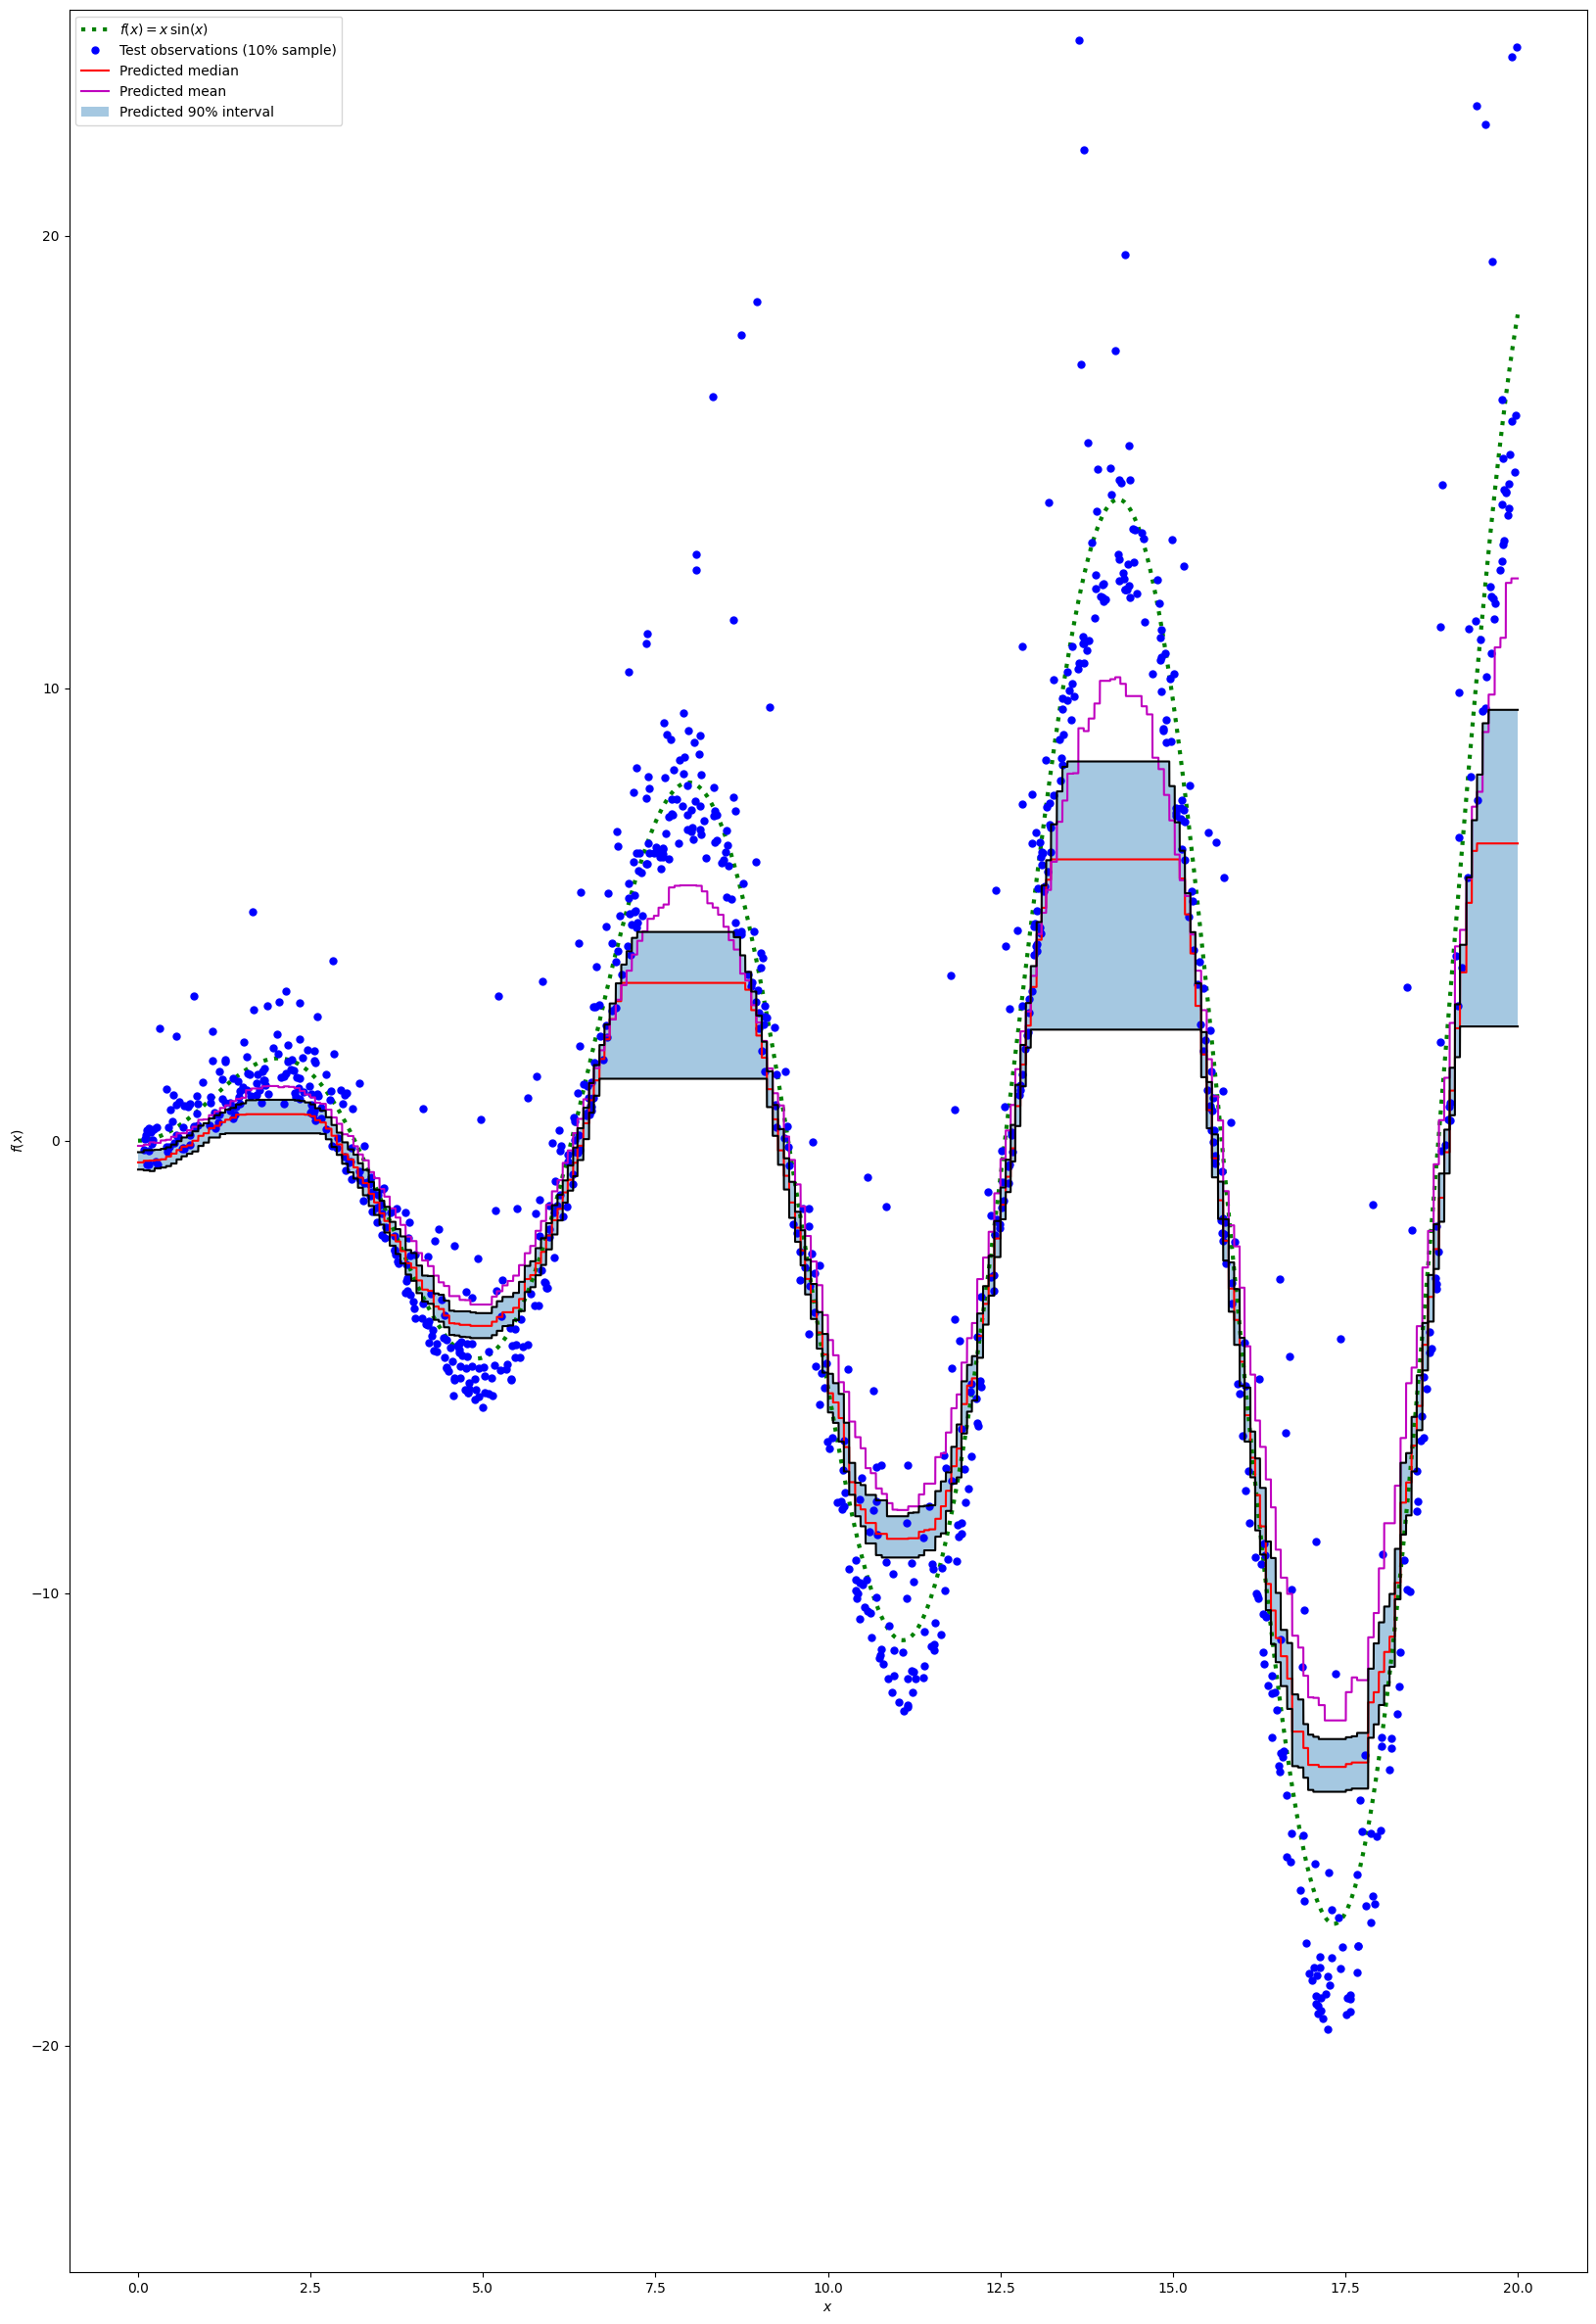

In [16]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(20, 30))
plt.plot(xx, f(xx), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
plt.plot(X_test[::10], y_test[::10], "b.", markersize=10, label="Test observations (10% sample)")
plt.plot(xx, y_med, "r-", label="Predicted median")
plt.plot(xx, y_pred, "m-", label="Predicted mean")
plt.plot(xx, y_upper, "k-")
plt.plot(xx, y_lower, "k-")
plt.fill_between(
    xx.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval"
)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.ylim(-25, 25)
plt.legend(loc="upper left")
plt.show()